In [1]:
# Import the needed model
import numpy as np
import matplotlib.pyplot as plt

### Controller Base Class

In [2]:
class Controller:
    # class type indication
    _ctype = "Controller"
    
    # Define the class initalization sequence. Constructor
    def __init__(self, start_time = 0):
        self._start_time      = start_time        
        self._last_timestamp  = 0
        self._set_point       = 0
        self._u               = 0.0            # this is the input to the plant
        self._hist_u_p        = [0]            # control effort history

    # Set the altitude set point
    def setTarget(self, target):
        self._set_point = float(target)
        
    # Retrive the current control effort
    def getPlantInput(self, time):
        self._last_timestamp = time
        self._hist_u_p.append(self._u)        
        return self._u
    
    # get the class type
    def getType(self):
        return self._ctype

### Open Controller Class. Inherited from the Basic Controller Class

In [3]:
class OpenController(Controller):
    # Define the class initalization sequence. Constructor
    def __init__(self, start_time = 0):
        Controller.__init__(self, start_time)
        self._ctype = "OpenController"
     
    # Set the desired control effort   
    def setControlEffort(self, control_effort):
        self._u = float(control_effort)

### Proportional Controller Class

In [4]:
class PController(Controller):
    def __init__(self, kp = 0.0, start_time = 0):
        Controller.__init__(self, start_time)
        self._kp = float(kp)
        self._ctype = "PController"

    # set the proportional constant
    def setKP(self, kp):
        self._kp = float(kp)

    # calculate the error and the input to the plant (Overriding the base class behaviour)
    def getPlantInput(self, measured_value, time):
        self._last_timestamp = time
        error = self._set_point - measured_value        
        self._u = self._kp * error
        self._hist_u_p.append(self._u)
        return self._u

### Proportional-Integratl Controller (PI - Controller)

In [5]:
class PIController(PController):
    def __init__(self, kp = 0.0, ki = 0.0, start_time = 0):
        PController.__init__(self, kp, start_time)
        self._ki       = float(ki)
        self._error_sum= 0.0
        self._ctype    = "PIController"
        self._hist_u_i = [0]                # Control effort history      
        
    def setKI(self, ki):
        self._ki = ki

    def getPlantInput(self, measured_value, time):        
        delta_time = time - self._last_timestamp
        if delta_time == 0:
            return 0
        
        self._last_timestamp = time
        error = self._set_point - measured_value     

        # Proportional error
        perr = self._kp * error
       
        # Calculate the error_sum (accumulate the integral error)
        self._error_sum += error * delta_time
        
        
        # Calculate the integral error here
        ierr = self._ki * self._error_sum
        
        # Set the control effort
        u = perr + ierr
        
        # Here we are storing the control effort history for post control
        self._hist_u_p.append(perr)
        self._hist_u_i.append(ierr)
        
        return u

### Proportional-Derivative Controller (PD - Controller)

In [6]:
class PDController(PController):
    def __init__(self, kp = 0.0, kd = 0.0, start_time = 0):
        PController.__init__(self, kp, start_time)
        self._kd         = float(kd)
        self._error_sum  = 0.0
        self._last_error = 0.0
        self._ctype      = "PDController"
        self._hist_u_d   = [0]                # Control effort history

        
    def setKD(self, kd):
        self._kd = float(kd)

    def getPlantInput(self, measured_value, time):
        delta_time = time - self._last_timestamp
        if delta_time == 0:
            return 0
        
        # Calculate the error 
        error = self._set_point - measured_value
        
        # Set the last_timestamp_ 
        self._last_timestamp = time

        # Find error_sum_
        self._error_sum += error * delta_time
        
        # Calculate the delta_error
        delta_error = error - self._last_error
        
        # Update the past error with the current error
        self._last_error = error

        # Proportional error
        perr = self._kp * error
       
        # Calculate the derivative error here. Be sure to access the 
        derr = self._kd * (delta_error / delta_time)
        
        # Set the control effort
        u = perr + derr
        
        # Here we are storing the control effort history for post control
        # observations. 
        self._hist_u_p.append(perr)
        self._hist_u_d.append(derr)

        return u

### Proportional-Integrative-Derivative Controller (PID - Controller)

In [7]:
class PIDController(PController):
    def __init__(self, kp = 0.0, kd = 0.0, ki = 0.0, start_time = 0):
        PController.__init__(self, kp, start_time)
        self._kd         = float(kd)
        self._ki         = float(ki)
        self._error_sum  = 0.0
        self._last_error = 0.0
        self._ctype      = "PIDController"
        self._hist_u_d   = [0]                # Control effort history
        self._hist_u_i   = [0]                # Control effort history
           
    def setKI(self, ki):
        self._ki = float(ki)
       
    def setKD(self, kd):
        self._kd = float(kd)

    def getPlantInput(self, measured_value, time):
        delta_time = time - self._last_timestamp
        if delta_time == 0:
            return 0
        
        # Calculate the error 
        error = self._set_point - measured_value
        
        # Set the last_timestamp_ 
        self._last_timestamp = time

        # Sum the errors
        self._error_sum += error * delta_time
        
        # Calculate the delta_error
        delta_error = error - self._last_error
        
        # Update the past error with the current error
        self._last_error = error
        
        # Proportional error
        perr = self._kp * error
       
        # Integral error
        ierr = self._ki * self._error_sum
       
        # Derivative error 
        derr = self._kd * (delta_error / delta_time)

        # Set the control effort
        u = perr + ierr + derr
        
        # Here we are storing the control effort history for post control
        # observations. 
        self._hist_u_p.append(perr)
        self._hist_u_i.append(ierr)
        self._hist_u_d.append(derr)

        return u

### PID - Controller with anti-windup and derivative smoothing effects

In [16]:
class PIDOptimalController(PIDController):
    def __init__(self, kp = 0.0, kd = 0.0, ki = 0.0, start_time = 0, max_windup = 20,
                 alpha = 1.0, u_bounds = [float('-inf'), float('inf')]):
        PIDController.__init__(self, kp, kd, ki, start_time)
        # Set max wind up
        self._max_windup = float(max_windup)
        # Set alpha for derivative filter smoothing factor
        self.alpha = float(alpha)
        # Set the controller type
        self._ctype      = "PIDOptimalController"        
        # Setting control effort saturation limits
        self.umin = u_bounds[0]
        self.umax = u_bounds[1]
        
    # Add a reset function to clear the class variables
    def reset(self):
        self._set_point = 0.0
        self._kp              = 0.0
        self._ki              = 0.0
        self._kd              = 0.0
        self._error_sum       = 0.0
        self._last_timestamp  = 0.0
        self._last_error      = 0
        self._last_last_error = 0
        self._last_windup     = 0.0
        
    # Create function to set max_windup_
    def setMaxWindup(self, max_windup):
        self._max_windup = int(max_windup)
        

    def getPlantInput(self, measured_value, time):
        delta_time = time - self._last_timestamp
        if delta_time == 0:
            return 0
        
        # Calculate the error 
        error = self._set_point - measured_value
        
        # Set the last_timestamp_ 
        self._last_timestamp = time

        # Sum the errors
        self._error_sum += error * delta_time
        
        # Calculate the delta_error
        delta_error = error - self._last_error
        
        # Update the past error with the current error
        self._last_error = error
        
        # Address the max windup
        ########################################
        if self._error_sum > self._max_windup:
            self._error_sum = self._max_windup
        elif self._error_sum < -self._max_windup:
            self._error_sum = -self._max_windup
        ########################################
        
        # Proportional error
        perr = self._kp * error
       
        # Integral error
        ierr = self._ki * self._error_sum
       
        # Recalculate the derivative error here incorporating derivative smoothing!
        derr = self._kd * (self.alpha * delta_error / delta_time + (1 - self.alpha)  * self._last_error)

        # Set the control effort
        u = perr + ierr + derr
        
        # Enforce actuator saturation limits
        if u > self.umax:
            u = self.umax
        elif u < self.umin:
            u = self.umin
        
        # Here we are storing the control effort history for post control
        # observations. 
        self._hist_u_p.append(perr)
        self._hist_u_i.append(ierr)
        self._hist_u_d.append(derr)

        return u

### Dynamic Equation of the System

In [21]:
def ydot(y, t, controller):
    ''' Returns the state vector at the next time-step

    Parameters:
    ----------
    y(k) = state vector, a length 2 list
      = [altitude, speed]
    t = time, (sec)
    pid = instance of the PIDController class

    Returns
    -------
    y(k+1) = [y[0], y[1]] = y(k) + ydot*dt
    '''

    # Model state
    #====================================
    y0 = y[0] # altitude, (m)
    y1 = y[1] # speed, (m/s)


    # Model parameters
    #====================================
    g = -9.81 # gravity, m/s/s
    m =  1.54 # quadrotor mass, kg
    c =  10.0 # electro-mechanical transmission constant

    # time step, (sec)
    #====================================
    dt = t - controller._last_timestamp
    
    # Control effort
    #====================================
    if controller.getType() == "OpenController":
        u = controller.getPlantInput(t)
    elif controller.getType() == "PController":
        u = controller.getPlantInput(y0, t)
    elif controller.getType() == "PIController":
        u = controller.getPlantInput(y0, t)
    elif controller.getType() == "PDController":
        u = controller.getPlantInput(y0, t)
    elif controller.getType() == "PIDController":
        u = controller.getPlantInput(y0, t)
    elif controller.getType() == "PIDOptimalController":
        u = controller.getPlantInput(y0, t)

    ### State derivatives
    #====================================
    if (y0 <= 0.):
        # if control input, u <= gravity, vehicle stays at rest on the ground
        # this prevents quadrotor from "falling" through the ground when thrust is
        # too small.
        if u <= np.absolute(g*m/c):
            y0dot = 0.
            y1dot = 0.
        else:  # else if u > gravity and quadrotor accelerates upwards
            y0dot = y1
            y1dot = g + c/m*u - 0.75*y1
    else: # otherwise quadrotor is already in the air
        y0dot = y1
        y1dot = g + c/m*u - 0.75*y1

    y0 += y0dot*dt
    y1 += y1dot*dt
    
    # add noise to the altitude
    if controller.getType() == "PIDOptimalController":
        sigma = 0.1
        y0 = np.random.normal(y0, sigma, 1)
    
    return [y0, y1]

### Simulation Parameter

In [10]:
cf   = 1.7                    # control effort in case of open loop controller
kp   = 0.5                    # proportional constant
ki   = 0.11                   # integral constant
kd   = 0.2                    # integral constant
umax = 5.0                    # max controller output, (N)
alpha = 1.0                   # derivative filter smoothing factor
N    = 600                    # number of simulation points
t0   = 0                      # starting time, (sec)
tf   = 45                     # end time, (sec)
time = np.linspace(t0, tf, N)
dt   = time[1] - time[0]      # delta t, (sec)

### Initializzation

In [11]:
# Inital conditions (i.e., initial state vector)
y = [0, 0]
   #y[0] = initial altitude, (m)
   #y[1] = initial speed, (m/s)

# Initialize array to store values, array of solution points
soln = np.zeros((len(time),len(y)))

### Select Controller Type for Simulation

In [18]:
# Create instance of Open_Controller class
#controller = OpenController()
#controller = PController(kp = kp)
#controller = PIController(kp = kp, ki = ki)
#controller = PDController(kp = kp, kd = kd)
controller = PIDController(kp = kp, ki = ki, kd = kd)
#controller = PIDOptimalController(kp = kp, ki = ki, kd = kd, max_windup = 1e6, u_bounds = [0, umax], alpha = alpha)

# Set altitude target
r = 10 # meters
controller.setTarget(r)

### Simulation (run)

In [19]:
j = 0 # dummy counter
for t in time:
    # Evaluate state at next time point
    y = ydot(y,t,controller)
    # Store results
    soln[j,:] = y
    j += 1

### Plot Results

<IPython.core.display.Javascript object>


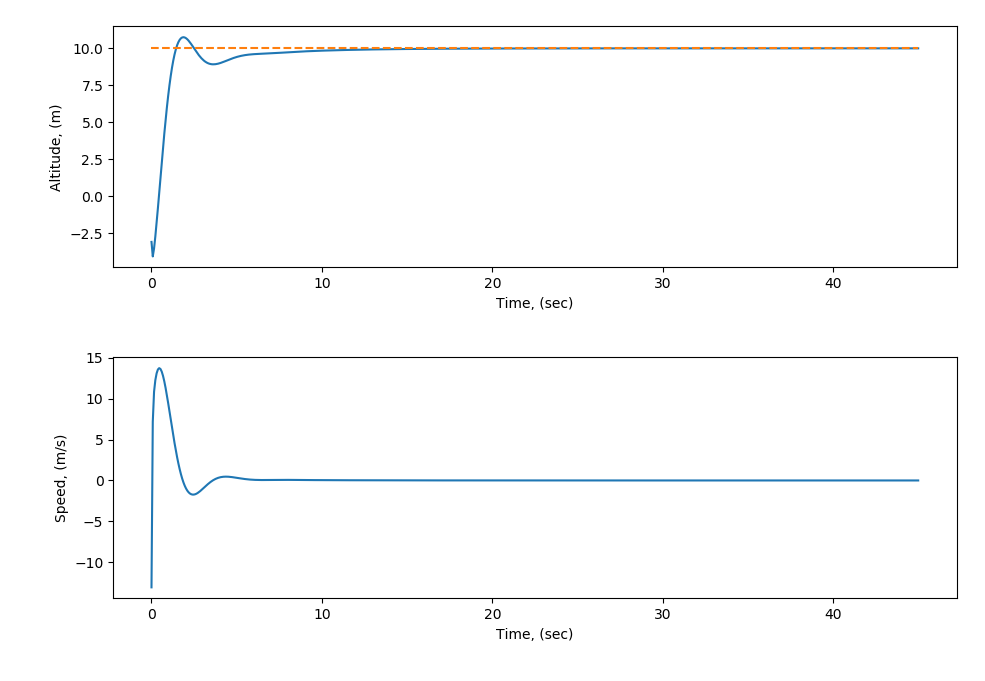

<IPython.core.display.Javascript object>


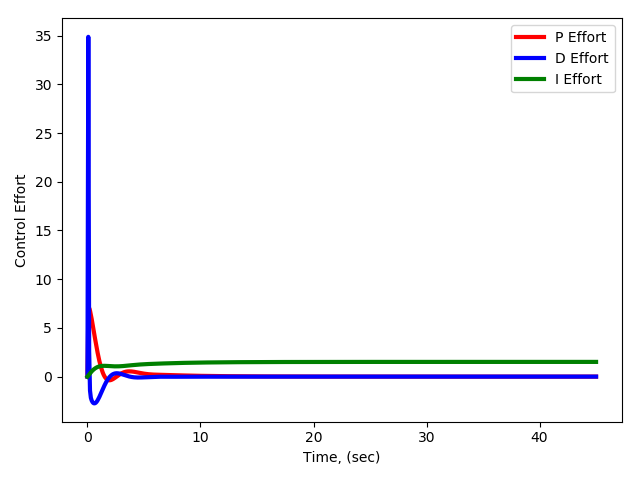

The rise time is 1.503 seconds
The percent overshoot is 7.5%
The offset from the target at 30 seconds is 0.000 meters


In [20]:
%matplotlib notebook

# Plot 1: This is the altitude of our quad copter as a function of time!
SP = np.ones_like(time)*r # altitude set point
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.plot(time, soln[:,0],time,SP,'--')
ax1.set_xlabel('Time, (sec)')
ax1.set_ylabel('Altitude, (m)')

# Plot 2: This is the speed of our quad copter as a function of time!
ax2 = fig.add_subplot(212)
ax2.plot(time, soln[:,1])
ax2.set_xlabel('Time, (sec)')
ax2.set_ylabel('Speed, (m/s)')
plt.tight_layout()
plt.show()

# Plot 3: This is the control effort applied to our quad copter as a function of time!
fig2 = plt.figure()
ax3 = fig2.add_subplot(111)
if controller.getType() == "OpenController":
    ax3.plot(time, controller._hist_u_p,   label='Open Effort', linewidth=3, color = 'red')
if controller.getType() == "PController":
    ax3.plot(time, controller._hist_u_p,   label='P Effort', linewidth=3, color = 'red')
if controller.getType() == "PIController":
    ax3.plot(time, controller._hist_u_p,   label='P Effort', linewidth=3, color = 'red')
    ax3.plot(time, controller._hist_u_i, label='I Effort', linewidth=3, color = 'blue')
if controller.getType() == "PDController":
    ax3.plot(time, controller._hist_u_p,   label='P Effort', linewidth=3, color = 'red')
    ax3.plot(time, controller._hist_u_d, label='D Effort', linewidth=3, color = 'blue')
if controller.getType() == "PIDController" or controller.getType() == "PIDOptimalController":
    ax3.plot(time, controller._hist_u_p,   label='P Effort', linewidth=3, color = 'red')
    ax3.plot(time, controller._hist_u_d, label='D Effort', linewidth=3, color = 'blue')
    ax3.plot(time, controller._hist_u_i, label='I Effort', linewidth=3, color = 'green')
ax3.set_xlabel('Time, (sec)')
ax3.set_ylabel('Control Effort')
h, l = ax3.get_legend_handles_labels()
ax3.legend(h, l)
plt.tight_layout()
plt.show()


##################
y0 = soln[:,0] #altitude
rise_time_index =  np.argmax(y0>r)
RT = time[rise_time_index]
print("The rise time is {0:.3f} seconds".format(RT))

OS = (np.max(y0) - r)/r*100
if OS < 0:
    OS = 0
print("The percent overshoot is {0:.1f}%".format(OS))

print ("The offset from the target at 30 seconds is {0:.3f} meters".format(abs(soln[-1,0]-r)))
